<img align="right" src="https://ds-cs-images.s3.ap-northeast-2.amazonaws.com/Codestates_Fulllogo_Color.png" width=100>

## *DATA SCIENCE / SECTION 2 / SPRINT 2 / NOTE 2*

# 📝 Assignment
---

# 랜덤포레스트(Random Forests)

### 1) 캐글 대회를 이어서 진행합니다. EDA, 데이터 전처리 부분을 업데이트 하세요.
- EDA는 항상 완벽할 수 없지요 한 주간 계속 같은 데이터로 과제를 진행하므로 부족한 부분을 추가하거나 논하세요.
- (지금은 feature engineering에 너무 시간을 들이지 마세요!)
- Ordinal Encoding을 적용해 보세요.
- **(객관식) 다음 특성들 중에 순서를 고려한 Ordinal Encoding이 필요해 보이는 특성을 선택하고 과제 제출폼에 제출하세요.**
    1. opinion_h1n1_vacc_effective
    2. state
    3. marital
    4. employment_occupation


In [1]:
import numpy as np
import pandas as pd

# 시각화
import matplotlib.pyplot as plt
import seaborn as sns

# 사이킷런 - 데이터 셋 나누기
from sklearn.model_selection import train_test_split

# 사이킷런 - encoders & imputers
from category_encoders import OneHotEncoder
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer 

# 사이킷런 - 파이프라인
from sklearn.pipeline import make_pipeline

# 사이킷런 - 학습모델
from sklearn.ensemble import RandomForestClassifier

# 사이킷런 - 모델 평가 지표
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

In [2]:
# 데이터 준비 - H1N1백신 관련 데이터

target = 'vacc_h1n1_f'
train = pd.merge(pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/vacc_flu/train.csv'), 
                 pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/vacc_flu/train_labels.csv')[target], left_index=True, right_index=True)
test = pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/vacc_flu/test.csv')
sample_submission = pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/vacc_flu/submission.csv')

In [3]:
# 컬럼 수 확인 (test가 1개 더 적다.)
train.shape, test.shape

((42154, 39), (28104, 38))

In [4]:
# train 컬럼 확인
train.columns

Index(['h1n1_concern', 'h1n1_knowledge', 'behavioral_antiviral_meds',
       'behavioral_avoidance', 'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chronic_med_condition', 'child_under_6_months', 'health_insurance',
       'health_worker', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
       'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective',
       'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'agegrp',
       'education_comp', 'raceeth4_i', 'sex_i', 'inc_pov', 'marital',
       'rent_own_r', 'employment_status', 'census_region', 'census_msa',
       'n_adult_r', 'household_children', 'n_people_r', 'employment_industry',
       'employment_occupation', 'hhs_region', 'state', 'vacc_h1n1_f'],
      dtype='object')

In [5]:
# train을 features & target으로 나눈다.
y_train = train[target]
X_train = train.drop(target, axis=1)

# 데이터셋 크기 확인 (train의 features, train의 target의 row수가 일치해야 한다.)
X_train.shape, y_train.shape

((42154, 38), (42154,))

### EDA (ref.)

In [6]:
# 데이터타입 확인
X_train.dtypes

h1n1_concern                   float64
h1n1_knowledge                 float64
behavioral_antiviral_meds      float64
behavioral_avoidance           float64
behavioral_face_mask           float64
behavioral_wash_hands          float64
behavioral_large_gatherings    float64
behavioral_outside_home        float64
behavioral_touch_face          float64
doctor_recc_h1n1               float64
doctor_recc_seasonal           float64
chronic_med_condition          float64
child_under_6_months           float64
health_insurance               float64
health_worker                  float64
opinion_h1n1_vacc_effective     object
opinion_h1n1_risk               object
opinion_h1n1_sick_from_vacc     object
opinion_seas_vacc_effective     object
opinion_seas_risk               object
opinion_seas_sick_from_vacc     object
agegrp                          object
education_comp                 float64
raceeth4_i                       int64
sex_i                            int64
inc_pov                  

In [7]:
test.dtypes

h1n1_concern                   float64
h1n1_knowledge                 float64
behavioral_antiviral_meds      float64
behavioral_avoidance           float64
behavioral_face_mask           float64
behavioral_wash_hands          float64
behavioral_large_gatherings    float64
behavioral_outside_home        float64
behavioral_touch_face          float64
doctor_recc_h1n1               float64
doctor_recc_seasonal           float64
chronic_med_condition          float64
child_under_6_months           float64
health_insurance               float64
health_worker                  float64
opinion_h1n1_vacc_effective     object
opinion_h1n1_risk               object
opinion_h1n1_sick_from_vacc     object
opinion_seas_vacc_effective     object
opinion_seas_risk               object
opinion_seas_sick_from_vacc     object
agegrp                          object
education_comp                 float64
raceeth4_i                       int64
sex_i                            int64
inc_pov                  

In [8]:
# features - 전반적 정보. numeric features 만 보여주었다.
X_train.describe()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,raceeth4_i,sex_i,inc_pov,marital,rent_own_r,census_region,n_adult_r,household_children,n_people_r,hhs_region
count,33734.000000,33734.000000,33635.000000,33482.000000,33710.000000,33683.000000,33640.000000,33633.000000,33571.000000,40269.000000,...,42154.000000,42154.000000,42154.000000,31955.000000,39958.000000,42154.000000,41845.000000,41845.000000,42020.000000,42154.000000
mean,1.617004,1.260272,0.050691,0.727824,0.067784,0.824333,0.355618,0.338239,0.678770,0.241724,...,2.830313,1.571832,2.132728,1.464059,2.915261,2.706457,1.937460,0.797156,2.738505,5.352991
std,0.910609,0.619327,0.219370,0.445087,0.251379,0.380542,0.478707,0.473117,0.466956,0.428133,...,0.651123,0.494819,0.991463,0.498714,12.597018,1.033513,0.745174,1.039354,1.393333,2.705101
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000
25%,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,3.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,0.000000,2.000000,3.000000
50%,2.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,...,3.000000,2.000000,2.000000,1.000000,1.000000,3.000000,2.000000,0.000000,2.000000,5.000000
75%,2.000000,2.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,...,3.000000,2.000000,3.000000,2.000000,2.000000,4.000000,2.000000,2.000000,4.000000,8.000000
max,3.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,4.000000,2.000000,4.000000,2.000000,99.000000,4.000000,4.000000,3.000000,7.000000,10.000000


In [9]:
test.describe()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,raceeth4_i,sex_i,inc_pov,marital,rent_own_r,census_region,n_adult_r,household_children,n_people_r,hhs_region
count,22492.000000,22492.000000,22432.000000,22294.000000,22478.000000,22456.000000,22421.000000,22422.000000,22384.000000,26897.000000,...,28104.000000,28104.000000,28104.000000,21281.000000,26664.000000,28104.000000,27919.000000,27919.000000,28020.000000,28104.000000
mean,1.612662,1.253957,0.046942,0.726832,0.070869,0.828331,0.353731,0.336455,0.682943,0.243113,...,2.829277,1.571769,2.122652,1.465627,2.855761,2.699082,1.934417,0.798130,2.736224,5.356391
std,0.907767,0.623000,0.211519,0.445596,0.256612,0.377101,0.478138,0.472507,0.465340,0.428971,...,0.654456,0.494831,0.986299,0.498829,12.366248,1.032444,0.740944,1.039314,1.387275,2.689989
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000
25%,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,3.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,0.000000,2.000000,3.000000
50%,2.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,...,3.000000,2.000000,2.000000,1.000000,1.000000,3.000000,2.000000,0.000000,2.000000,5.000000
75%,2.000000,2.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,...,3.000000,2.000000,3.000000,2.000000,2.000000,4.000000,2.000000,2.000000,4.000000,8.000000
max,3.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,4.000000,2.000000,4.000000,2.000000,99.000000,4.000000,4.000000,3.000000,7.000000,10.000000


In [10]:
# features - 중복값 확인 : 없음
X_train.T.duplicated()

h1n1_concern                   False
h1n1_knowledge                 False
behavioral_antiviral_meds      False
behavioral_avoidance           False
behavioral_face_mask           False
behavioral_wash_hands          False
behavioral_large_gatherings    False
behavioral_outside_home        False
behavioral_touch_face          False
doctor_recc_h1n1               False
doctor_recc_seasonal           False
chronic_med_condition          False
child_under_6_months           False
health_insurance               False
health_worker                  False
opinion_h1n1_vacc_effective    False
opinion_h1n1_risk              False
opinion_h1n1_sick_from_vacc    False
opinion_seas_vacc_effective    False
opinion_seas_risk              False
opinion_seas_sick_from_vacc    False
agegrp                         False
education_comp                 False
raceeth4_i                     False
sex_i                          False
inc_pov                        False
marital                        False
r

In [11]:
test.T.duplicated()

h1n1_concern                   False
h1n1_knowledge                 False
behavioral_antiviral_meds      False
behavioral_avoidance           False
behavioral_face_mask           False
behavioral_wash_hands          False
behavioral_large_gatherings    False
behavioral_outside_home        False
behavioral_touch_face          False
doctor_recc_h1n1               False
doctor_recc_seasonal           False
chronic_med_condition          False
child_under_6_months           False
health_insurance               False
health_worker                  False
opinion_h1n1_vacc_effective    False
opinion_h1n1_risk              False
opinion_h1n1_sick_from_vacc    False
opinion_seas_vacc_effective    False
opinion_seas_risk              False
opinion_seas_sick_from_vacc    False
agegrp                         False
education_comp                 False
raceeth4_i                     False
sex_i                          False
inc_pov                        False
marital                        False
r

In [12]:
# features - 결측치 확인
# train : 42,154
X_train.isnull().sum()

h1n1_concern                    8420
h1n1_knowledge                  8420
behavioral_antiviral_meds       8519
behavioral_avoidance            8672
behavioral_face_mask            8444
behavioral_wash_hands           8471
behavioral_large_gatherings     8514
behavioral_outside_home         8521
behavioral_touch_face           8583
doctor_recc_h1n1                1885
doctor_recc_seasonal            1885
chronic_med_condition           1317
child_under_6_months            9449
health_insurance               19421
health_worker                   9430
opinion_h1n1_vacc_effective     8779
opinion_h1n1_risk               8825
opinion_h1n1_sick_from_vacc     8869
opinion_seas_vacc_effective     8934
opinion_seas_risk               9001
opinion_seas_sick_from_vacc     9065
agegrp                             0
education_comp                 10166
raceeth4_i                         0
sex_i                              0
inc_pov                            0
marital                        10199
r

In [13]:
# test : 28,104
test.isnull().sum()

h1n1_concern                    5612
h1n1_knowledge                  5612
behavioral_antiviral_meds       5672
behavioral_avoidance            5810
behavioral_face_mask            5626
behavioral_wash_hands           5648
behavioral_large_gatherings     5683
behavioral_outside_home         5682
behavioral_touch_face           5720
doctor_recc_h1n1                1207
doctor_recc_seasonal            1207
chronic_med_condition            854
child_under_6_months            6291
health_insurance               12740
health_worker                   6270
opinion_h1n1_vacc_effective     5864
opinion_h1n1_risk               5903
opinion_h1n1_sick_from_vacc     5933
opinion_seas_vacc_effective     5957
opinion_seas_risk               5993
opinion_seas_sick_from_vacc     6035
agegrp                             0
education_comp                  6811
raceeth4_i                         0
sex_i                              0
inc_pov                            0
marital                         6823
r

In [14]:
# features- object컬럼의 cardinality확인

# object 타입의 features를 고르기
object_data = []

for col in X_train.columns:
    if X_train[col].dtype=="object":
        object_data.append(col)
    

object_data

['opinion_h1n1_vacc_effective',
 'opinion_h1n1_risk',
 'opinion_h1n1_sick_from_vacc',
 'opinion_seas_vacc_effective',
 'opinion_seas_risk',
 'opinion_seas_sick_from_vacc',
 'agegrp',
 'employment_status',
 'census_msa',
 'employment_industry',
 'employment_occupation',
 'state']

In [15]:
X_train[object_data].describe().T.sort_values(by='unique')

,count,unique,top,freq
employment_status,31876,3,Employed,17173
census_msa,42154,3,"MSA, Not Principle City",18957
opinion_h1n1_vacc_effective,33375,6,Somewhat Effective,14729
opinion_h1n1_risk,33329,6,Somewhat Low,12520
opinion_h1n1_sick_from_vacc,33285,6,Not Very Worried,11582
opinion_seas_vacc_effective,33220,6,Somewhat Effective,14543
opinion_seas_risk,33153,6,Somewhat Low,11397
opinion_seas_sick_from_vacc,33089,6,Not At All Worried,14749
agegrp,42154,7,65+ Years,8517
employment_industry,17165,23,Health Care and Social Assistance Industries,3086


In [16]:
# target - 구성 비율 확인 & 시각화
proportion = pd.DataFrame(y_train.value_counts())
proportion

,vacc_h1n1_f
0,32077
1,10077


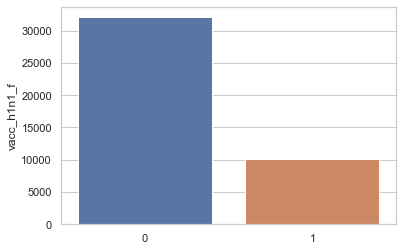

In [17]:
# 시각화
df_target = pd.DataFrame(y_train)

sns.set_theme(style="whitegrid")
ax = sns.barplot(x=proportion.index, y=target, data=proportion)
plt.show()

In [18]:
# opinion_h1n1_vacc_effective, state, marital, employment_occupation 비교
# Ordinal Encoding의 용도 및 쓰임새 : 중요도, 순번 등, "순서"에 가치부여가 필요한 특성에 주로 사용한다. 

In [19]:
# opinion_h1n1_vacc_effective
# 설문조사로 따지면 매우 그렇다 - 그렇다 - 보통이다 - 아니다 - 매우 아니다 등으로 생각할 수 있다.
# 이는 점수로 환산하면 긍정적/부정적 성향을 어림 잡아 판단할 수 있다. 
# 따라서 Ordinal Encoding이 필요한 컬럼은 "opinion_h1n1_vacc_effective"이다. 
train["opinion_h1n1_vacc_effective"].value_counts()

Somewhat Effective      14729
Very Effective           9052
Dont Know                6033
Not Very Effective       2312
Not At All Effective     1111
Refused                   138
Name: opinion_h1n1_vacc_effective, dtype: int64

In [20]:
# "주"
# 순서에 크게 연연하지 않는다.
train["state"].value_counts()

NEW MEXICO             1017
TEXAS                  1012
CALIFORNIA              992
VIRGINIA                982
MARYLAND                978
GEORGIA                 963
ILLINOIS                933
DISTRICTOF COLUMBIA     927
MISSISSIPPI             897
UTAH                    894
NEW YORK                892
FLORIDA                 890
ARIZONA                 887
LOUISIANA               884
ALASKA                  876
NEW JERSEY              867
NORTH CAROLINA          860
ALABAMA                 856
COLORADO                850
WASHINGTON              834
NEVADA                  834
ARKANSAS                826
INDIANA                 821
WYOMING                 820
DELAWARE                820
OREGON                  818
IDAHO                   818
NEBRASKA                810
KANSAS                  805
SOUTH CAROLINA          796
IOWA                    791
MASSACHUSETTS           791
OKLAHOMA                783
CONNECTICUT             783
RHODE ISLAND            778
OHIO                

In [21]:
# 결혼 여부
# binary - Ordinal Encoding이 필요 없다.
train["marital"].value_counts()

1.0    17126
2.0    14829
Name: marital, dtype: int64

In [22]:
# 응답자의 직업군
# "주"와 마찬가지로 순서에 크게 연연하지 않는 특성이다.
train["employment_occupation"].value_counts()

Management Occupations                                       2188
Office and Administrative Support Occupations                1931
Education, Training, and Library Occupations                 1609
Healthcare Practitioners and Technical Occupations           1535
Sales and Related Occupations                                1404
Business and Financial Operations Occupations                 946
Construction and Extraction Occupations                       672
Production Occupations                                        614
Transportation and Material Moving Occupations                612
Computer and Mathematical Occupations                         589
Food Preparation and Serving Related Occupations              523
Arts, Design, Entertainment, Sports and Media Occupations     457
Architecture and Engineering Occupations                      447
Community and Social Services Occupations                     435
Personal Care and Service Occupations                         429
Building a

### Feature Engineering (ref.)

In [23]:
X_train.columns

Index(['h1n1_concern', 'h1n1_knowledge', 'behavioral_antiviral_meds',
       'behavioral_avoidance', 'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chronic_med_condition', 'child_under_6_months', 'health_insurance',
       'health_worker', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
       'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective',
       'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'agegrp',
       'education_comp', 'raceeth4_i', 'sex_i', 'inc_pov', 'marital',
       'rent_own_r', 'employment_status', 'census_region', 'census_msa',
       'n_adult_r', 'household_children', 'n_people_r', 'employment_industry',
       'employment_occupation', 'hhs_region', 'state'],
      dtype='object')

In [24]:
# 1. 지역 관련 컬럼 통합
# hhs_region : U.S. Department of Health & Human Services에서는 관할구역을 지정하고 branch office를 설치하여 관리,감독하고 있다.
# 백신은 보건 관련 정보이므로, hhs_region정보는 살려둔다.

# 1~10까지 있는지 확인
X_train["hhs_region"].value_counts().sort_index(ascending=True)

1     4527
2     1759
3     5178
4     6751
5     4793
6     4522
7     3154
8     4684
9     3440
10    3346
Name: hhs_region, dtype: int64

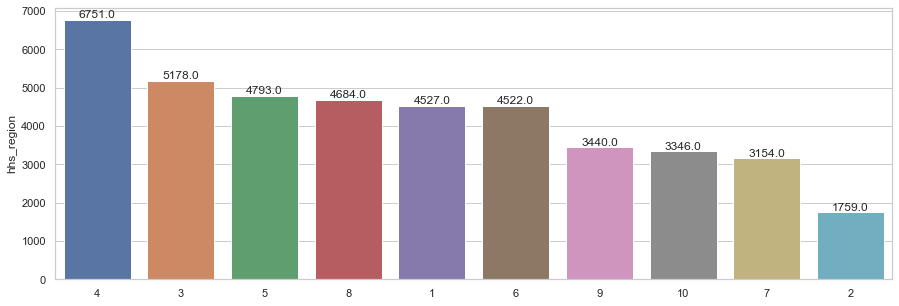

In [25]:
# 어느 지역이 가장 많은지? - 시각화
df_hhs_region = pd.DataFrame(X_train["hhs_region"].value_counts())

sns.set_theme(style="whitegrid")
plt.subplots(figsize=(15, 5))
ax = sns.barplot(x=df_hhs_region.index, y="hhs_region", data=df_hhs_region, order = df_hhs_region.index)

for p in ax.patches: 
    left, bottom, width, height = p.get_bbox().bounds 
    ax.annotate(p.get_height(), (left+width/2, height*1.01), ha='center')
    
plt.show()

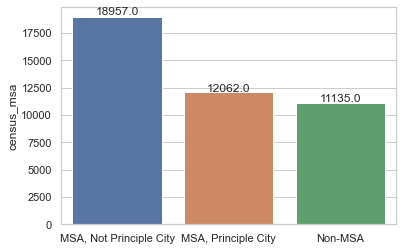

In [26]:
# census_region, census_msa 는 인구 밀도/분포와 관련 되어 있다 -> 지리적 위치가 더 궁금하므로 census_msa를 drop해본다.

# drop전에 - 어떤 모양인가?
df_cencus_msa = pd.DataFrame(X_train["census_msa"].value_counts())

sns.set_theme(style="whitegrid")
ax = sns.barplot(x=df_cencus_msa.index, y="census_msa", data=df_cencus_msa)

for p in ax.patches: 
    left, bottom, width, height = p.get_bbox().bounds 
    ax.annotate(p.get_height(), (left+width/2, height*1.01), ha='center')
    
plt.show()

In [27]:
X_train.drop("census_msa", axis=1, inplace=True)  # 1회만 실행
X_train

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,rent_own_r,employment_status,census_region,n_adult_r,household_children,n_people_r,employment_industry,employment_occupation,hhs_region,state
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,...,2.0,NaN,4,2.0,3.0,5.0,NaN,NaN,9,CALIFORNIA
1,3.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,Employed,2,1.0,0.0,1.0,Accommodation and Food Services Industries,Food Preparation and Serving Related Occupations,7,NEBRASKA
2,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,2.0,Employed,1,1.0,2.0,3.0,Transportation and Warehousing Industries,Transportation and Material Moving Occupations,1,MASSACHUSETTS
3,2.0,2.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,Employed,3,2.0,2.0,4.0,"Professional, Scientific, and Technical Servic...",Legal Occupations,6,LOUISIANA
4,1.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,Employed,3,3.0,0.0,3.0,Education Services Industries,Office and Administrative Support Occupations,4,ALABAMA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42149,2.0,2.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,1.0,NaN,3,2.0,1.0,3.0,NaN,NaN,6,TEXAS
42150,2.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,Employed,3,2.0,0.0,2.0,Health Care and Social Assistance Industries,Healthcare Practitioners and Technical Occupat...,3,VIRGINIA
42151,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,2.0,Employed,3,2.0,3.0,5.0,Retail Trade Industries,Office and Administrative Support Occupations,4,TENNESSEE
42152,2.0,2.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,NaN,...,1.0,Employed,3,2.0,0.0,2.0,Health Care and Social Assistance Industries,Healthcare Practitioners and Technical Occupat...,4,GEORGIA


In [28]:
# test에서도 잊지 않고 해 준다.
X_test = test.drop("census_msa", axis=1)   # 1회만 실행
X_test

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,rent_own_r,employment_status,census_region,n_adult_r,household_children,n_people_r,employment_industry,employment_occupation,hhs_region,state
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,Employed,2,2.0,0.0,2.0,Health Care and Social Assistance Industries,Healthcare Practitioners and Technical Occupat...,7,KANSAS
1,3.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,NaN,NaN,3,1.0,0.0,1.0,NaN,NaN,6,LOUISIANA
2,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,...,1.0,Not in Labor Force,1,1.0,0.0,1.0,NaN,NaN,1,NEW HAMPSHIRE
3,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,Not in Labor Force,4,2.0,0.0,2.0,NaN,NaN,9,CALIFORNIA
4,2.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,Not in Labor Force,1,1.0,0.0,1.0,NaN,NaN,1,NEW HAMPSHIRE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28099,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,...,2.0,Not in Labor Force,2,3.0,1.0,4.0,NaN,NaN,7,MISSOURI
28100,3.0,2.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,...,1.0,Employed,3,2.0,0.0,2.0,Education Services Industries,"Education, Training, and Library Occupations",4,MISSISSIPPI
28101,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,...,1.0,Not in Labor Force,4,3.0,0.0,3.0,NaN,NaN,9,CALIFORNIA
28102,2.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,99.0,Employed,2,2.0,2.0,4.0,Transportation and Warehousing Industries,Office and Administrative Support Occupations,7,NEBRASKA


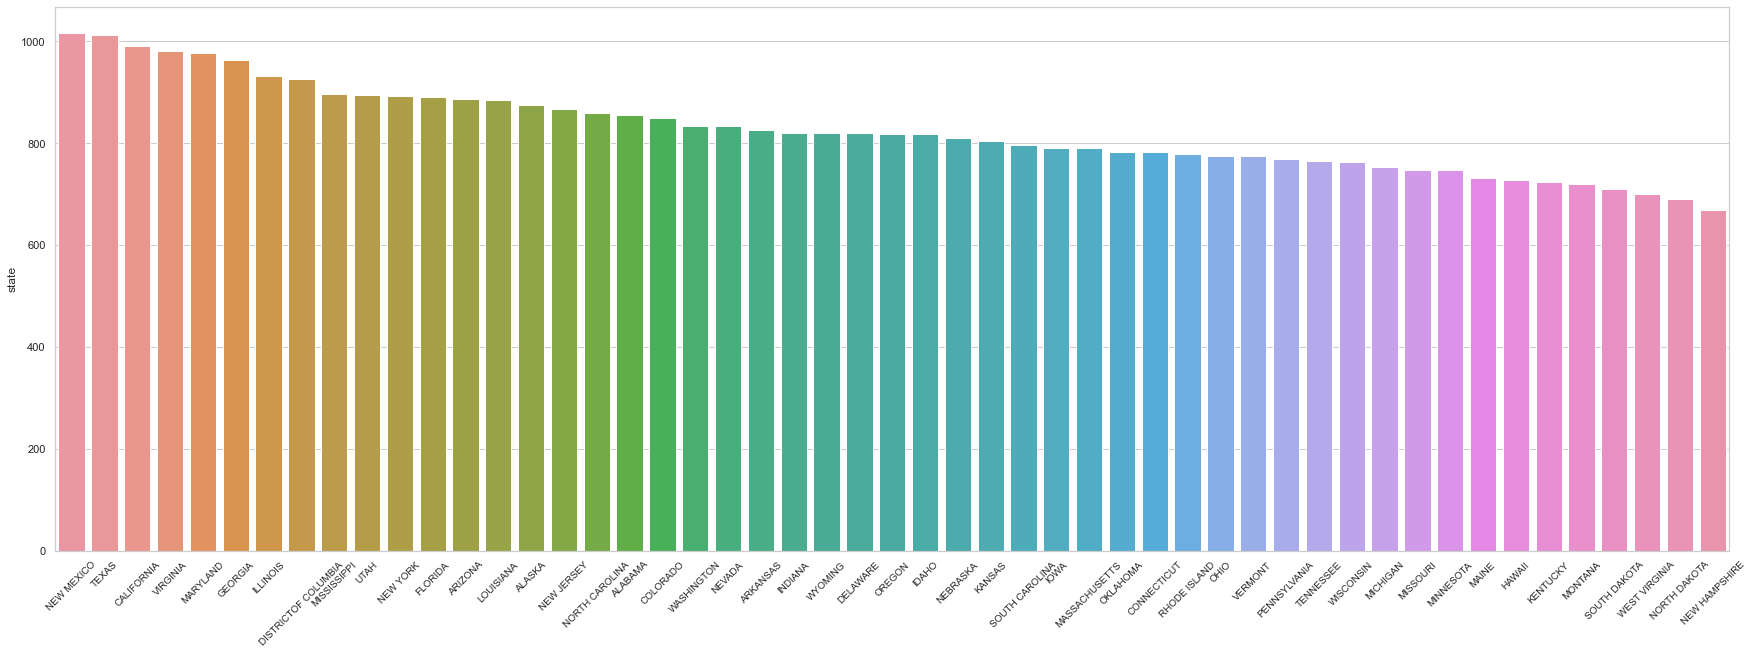

In [29]:
# state - DecisionTree에서는 삭제하였으나, 이번에는 살려서 사용해본다.

# 시각화로 현황 파악#
df_state = pd.DataFrame(X_train["state"].value_counts())

sns.set_theme(style="whitegrid")
plt.subplots(figsize=(30,10))
plt.xticks(rotation = 45, fontweight='light', fontsize='small' )
ax = sns.barplot(x=df_state.index, y="state", data=df_state)

plt.show()

In [30]:
# 2. 거주 구성원 - 어른 & 아이 확인
X_train[["n_adult_r", "household_children", "n_people_r"]]

,n_adult_r,household_children,n_people_r
0,2.0,3.0,5.0
1,1.0,0.0,1.0
2,1.0,2.0,3.0
3,2.0,2.0,4.0
4,3.0,0.0,3.0
...,...,...,...
42149,2.0,1.0,3.0
42150,2.0,0.0,2.0
42151,2.0,3.0,5.0
42152,2.0,0.0,2.0


In [31]:
# 정보 확인
# 어른 인원 + 어린이 인원 = 총 인원.
# 어린이 인원의 비율 컬럼을 만들어보자.
X_train[["n_adult_r", "household_children", "n_people_r"]].describe()

,n_adult_r,household_children,n_people_r
count,41845.000000,41845.000000,42020.000000
mean,1.937460,0.797156,2.738505
std,0.745174,1.039354,1.393333
min,1.000000,0.000000,1.000000
25%,1.000000,0.000000,2.000000
50%,2.000000,0.000000,2.000000
75%,2.000000,2.000000,4.000000
max,4.000000,3.000000,7.000000


In [32]:
# 어린이 인원 수 / 전체 인원수 * 100
X_train["proportion_child"] = round((X_train["household_children"]/X_train["n_people_r"])*100, 0)

# 확인
X_train["proportion_child"].head(10)

0    60.0
1     0.0
2    67.0
3    50.0
4     0.0
5    33.0
6    25.0
7     0.0
8    50.0
9    60.0
Name: proportion_child, dtype: float64

In [33]:
# test에서도 잊지 않고 해 준다.
X_test["proportion_child"] = round((test["household_children"]/test["n_people_r"])*100, 0)

# 확인
X_test["proportion_child"].head(10)

0     0.0
1     0.0
2     0.0
3     0.0
4     0.0
5    50.0
6     0.0
7    50.0
8     0.0
9     0.0
Name: proportion_child, dtype: float64

In [34]:
# 모델 성능 유추를 위한 검증 데이터셋 나누기
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state = 0)

In [35]:
X_train.shape, y_train.shape

((33723, 38), (33723,))

In [36]:
X_val.shape, y_val.shape

((8431, 38), (8431,))

In [37]:
X_test.shape

(28104, 38)

### 2) 랜덤포레스트 모델을 적용한 후의 결과를 캐글에 제출하세요.
- 랜덤포레스트를 적용하고 성능이 오히려 떨어졌을 수도 있습니다! 만약 그렇다면 이유를 본인 논리로 분석해 보세요.
- **캐글 Leaderboard의 본인 Score를 과제 제출폼에 제출하세요.**

In [45]:
# 특성별로 인코더를 따로 정해 주고 싶었기 때문에, 특성 이름을 모아 리스트로 설정

# onehot 할 특성
onehot = ['sex_i','agegrp','raceeth4_i','marital','rent_own_r','employment_status',
          'census_region','hhs_region', 'state','employment_industry','employment_occupation','education_comp']

# ordinal 할 특성
ordinal = ['opinion_h1n1_vacc_effective','opinion_h1n1_risk','opinion_h1n1_sick_from_vacc',
           'opinion_seas_vacc_effective','opinion_seas_risk','opinion_seas_sick_from_vacc']

In [50]:
# 1. 모든 특성을 일괄적으로 OneHotEncoding
pipe1 = make_pipeline(
    OneHotEncoder(use_cat_names=True), 
    SimpleImputer(), 
    RandomForestClassifier(n_jobs=-1, random_state=10, oob_score=True)
)

pipe1.fit(X_train, y_train)
print('검증 정확도: ', pipe1.score(X_val, y_val))

y_pred1 = pipe1.predict(X_val)
print('검증 f1: ', f1_score(y_val, y_pred1))

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


검증 정확도:  0.8246945795279327
검증 f1:  0.5482885085574573


In [52]:
# 2. 모든 특성을 일괄적으로 OrdinalEncoding
pipe2 = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(), 
    RandomForestClassifier(n_jobs=-1, random_state=10, oob_score=True)
)

pipe2.fit(X_train, y_train)
print('검증 정확도: ', pipe2.score(X_val, y_val))

y_pred2 = pipe1.predict(X_val)
print('검증 f1: ', f1_score(y_val, y_pred2))

검증 정확도:  0.8249317993120626
검증 f1:  0.5482885085574573


In [53]:
# 3. 모든 특성을 일괄적으로 OrdinalEncoding > SimpleImputer > RandomForestClassifier parameter 추가 설정
pipe3 = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(), 
    RandomForestClassifier(n_jobs=-1, random_state=10, oob_score=True, n_estimators = 200, min_samples_split = 12)
)

pipe3.fit(X_train, y_train)
print('검증 정확도: ', pipe3.score(X_val, y_val))

y_pred3 = pipe3.predict(X_val)
print('검증 f1: ', f1_score(y_val, y_pred3))

검증 정확도:  0.8308622939153125
검증 f1:  0.5689238210399032


In [54]:
# 4. 일부 특성 OneHot > 일부 특성 Ordinal > SimpleImputer > RandomForestClassifier
pipe4 = make_pipeline(
    OneHotEncoder(use_cat_names=True, cols=onehot), 
    OrdinalEncoder(cols=ordinal),
    SimpleImputer(), 
    RandomForestClassifier(n_jobs=-1, random_state=10, oob_score=True)
)

pipe4.fit(X_train, y_train)
print('검증 정확도: ', pipe4.score(X_val, y_val))

y_pred4 = pipe4.predict(X_val)
print('검증 f1: ', f1_score(y_val, y_pred4))

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


검증 정확도:  0.8155616178389278
검증 f1:  0.5139105970615818


In [55]:
# 5. 일부 특성 OneHot > 일부 특성 Ordinal > SimpleImputer > RandomForestClassifier parameter 추가 설정
pipe4 = make_pipeline(
    OneHotEncoder(use_cat_names=True, cols=onehot), 
    OrdinalEncoder(cols=ordinal),
    SimpleImputer(), 
    RandomForestClassifier(n_jobs=-1, random_state=10, oob_score=True, n_estimators = 200, min_samples_split = 12)
)

pipe4.fit(X_train, y_train)
print('검증 정확도: ', pipe4.score(X_val, y_val))

y_pred4 = pipe4.predict(X_val)
print('검증 f1: ', f1_score(y_val, y_pred4))

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


검증 정확도:  0.8248131894199976
검증 f1:  0.5342163355408388


In [57]:
# 6. 일부 특성 OneHot > 일부 특성 Ordinal > SimpleImputer > RandomForestClassifier parameter 추가 설정
pipe4 = make_pipeline(
    OneHotEncoder(use_cat_names=True, cols=onehot), 
    OrdinalEncoder(cols=ordinal),
    SimpleImputer(), 
    RandomForestClassifier(n_jobs=-1, random_state=10, oob_score=True, n_estimators = 150, min_samples_split = 6)
)

pipe4.fit(X_train, y_train)
print('검증 정확도: ', pipe4.score(X_val, y_val))

y_pred4 = pipe4.predict(X_val)
print('검증 f1: ', f1_score(y_val, y_pred4))

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


검증 정확도:  0.8237457003914126
검증 f1:  0.5341692789968652


### kaggle제출 (가장 좋았던 모델로 수행)

In [60]:
# test 데이터의 feature를 사용하여 예측값 도출
y_pred_test = pipe3.predict(X_test)

In [61]:
# 예측값을 제출 form에 저장
sample_submission[target] = y_pred_test
sample_submission

,Id,vacc_h1n1_f
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
28099,28099,0
28100,28100,0
28101,28101,0
28102,28102,0


In [62]:
# 개수 확인 (예측값에서 0, 1 개수 확인)
(y_pred_test == 0).sum(), (y_pred_test == 1).sum()

(24042, 4062)

In [63]:
# 개수 확인 (제출폼 데이터프레임에서 0, 1 개수 확인)
sample_submission[target].value_counts()

0    24042
1     4062
Name: vacc_h1n1_f, dtype: int64

In [64]:
# 저장
sample_submission.to_csv("./submission_dana_randomforest.csv", index = False)